In [1]:
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scFates as scf
import cellrank as cr
import scvelo as scv

cr.settings.verbosity = 2
sc.settings.set_figure_params(frameon=False, dpi=100)
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [3]:
# Load the data
adata = sc.read_h5ad("/Users/ryang/Documents/Academics/Spring 2024/CSCB/Homework/HW4/adHW4_031324.h5ad")
adata.shape

(2589, 29452)

In [87]:
# Preprocess
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata, use_highly_variable=True)

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

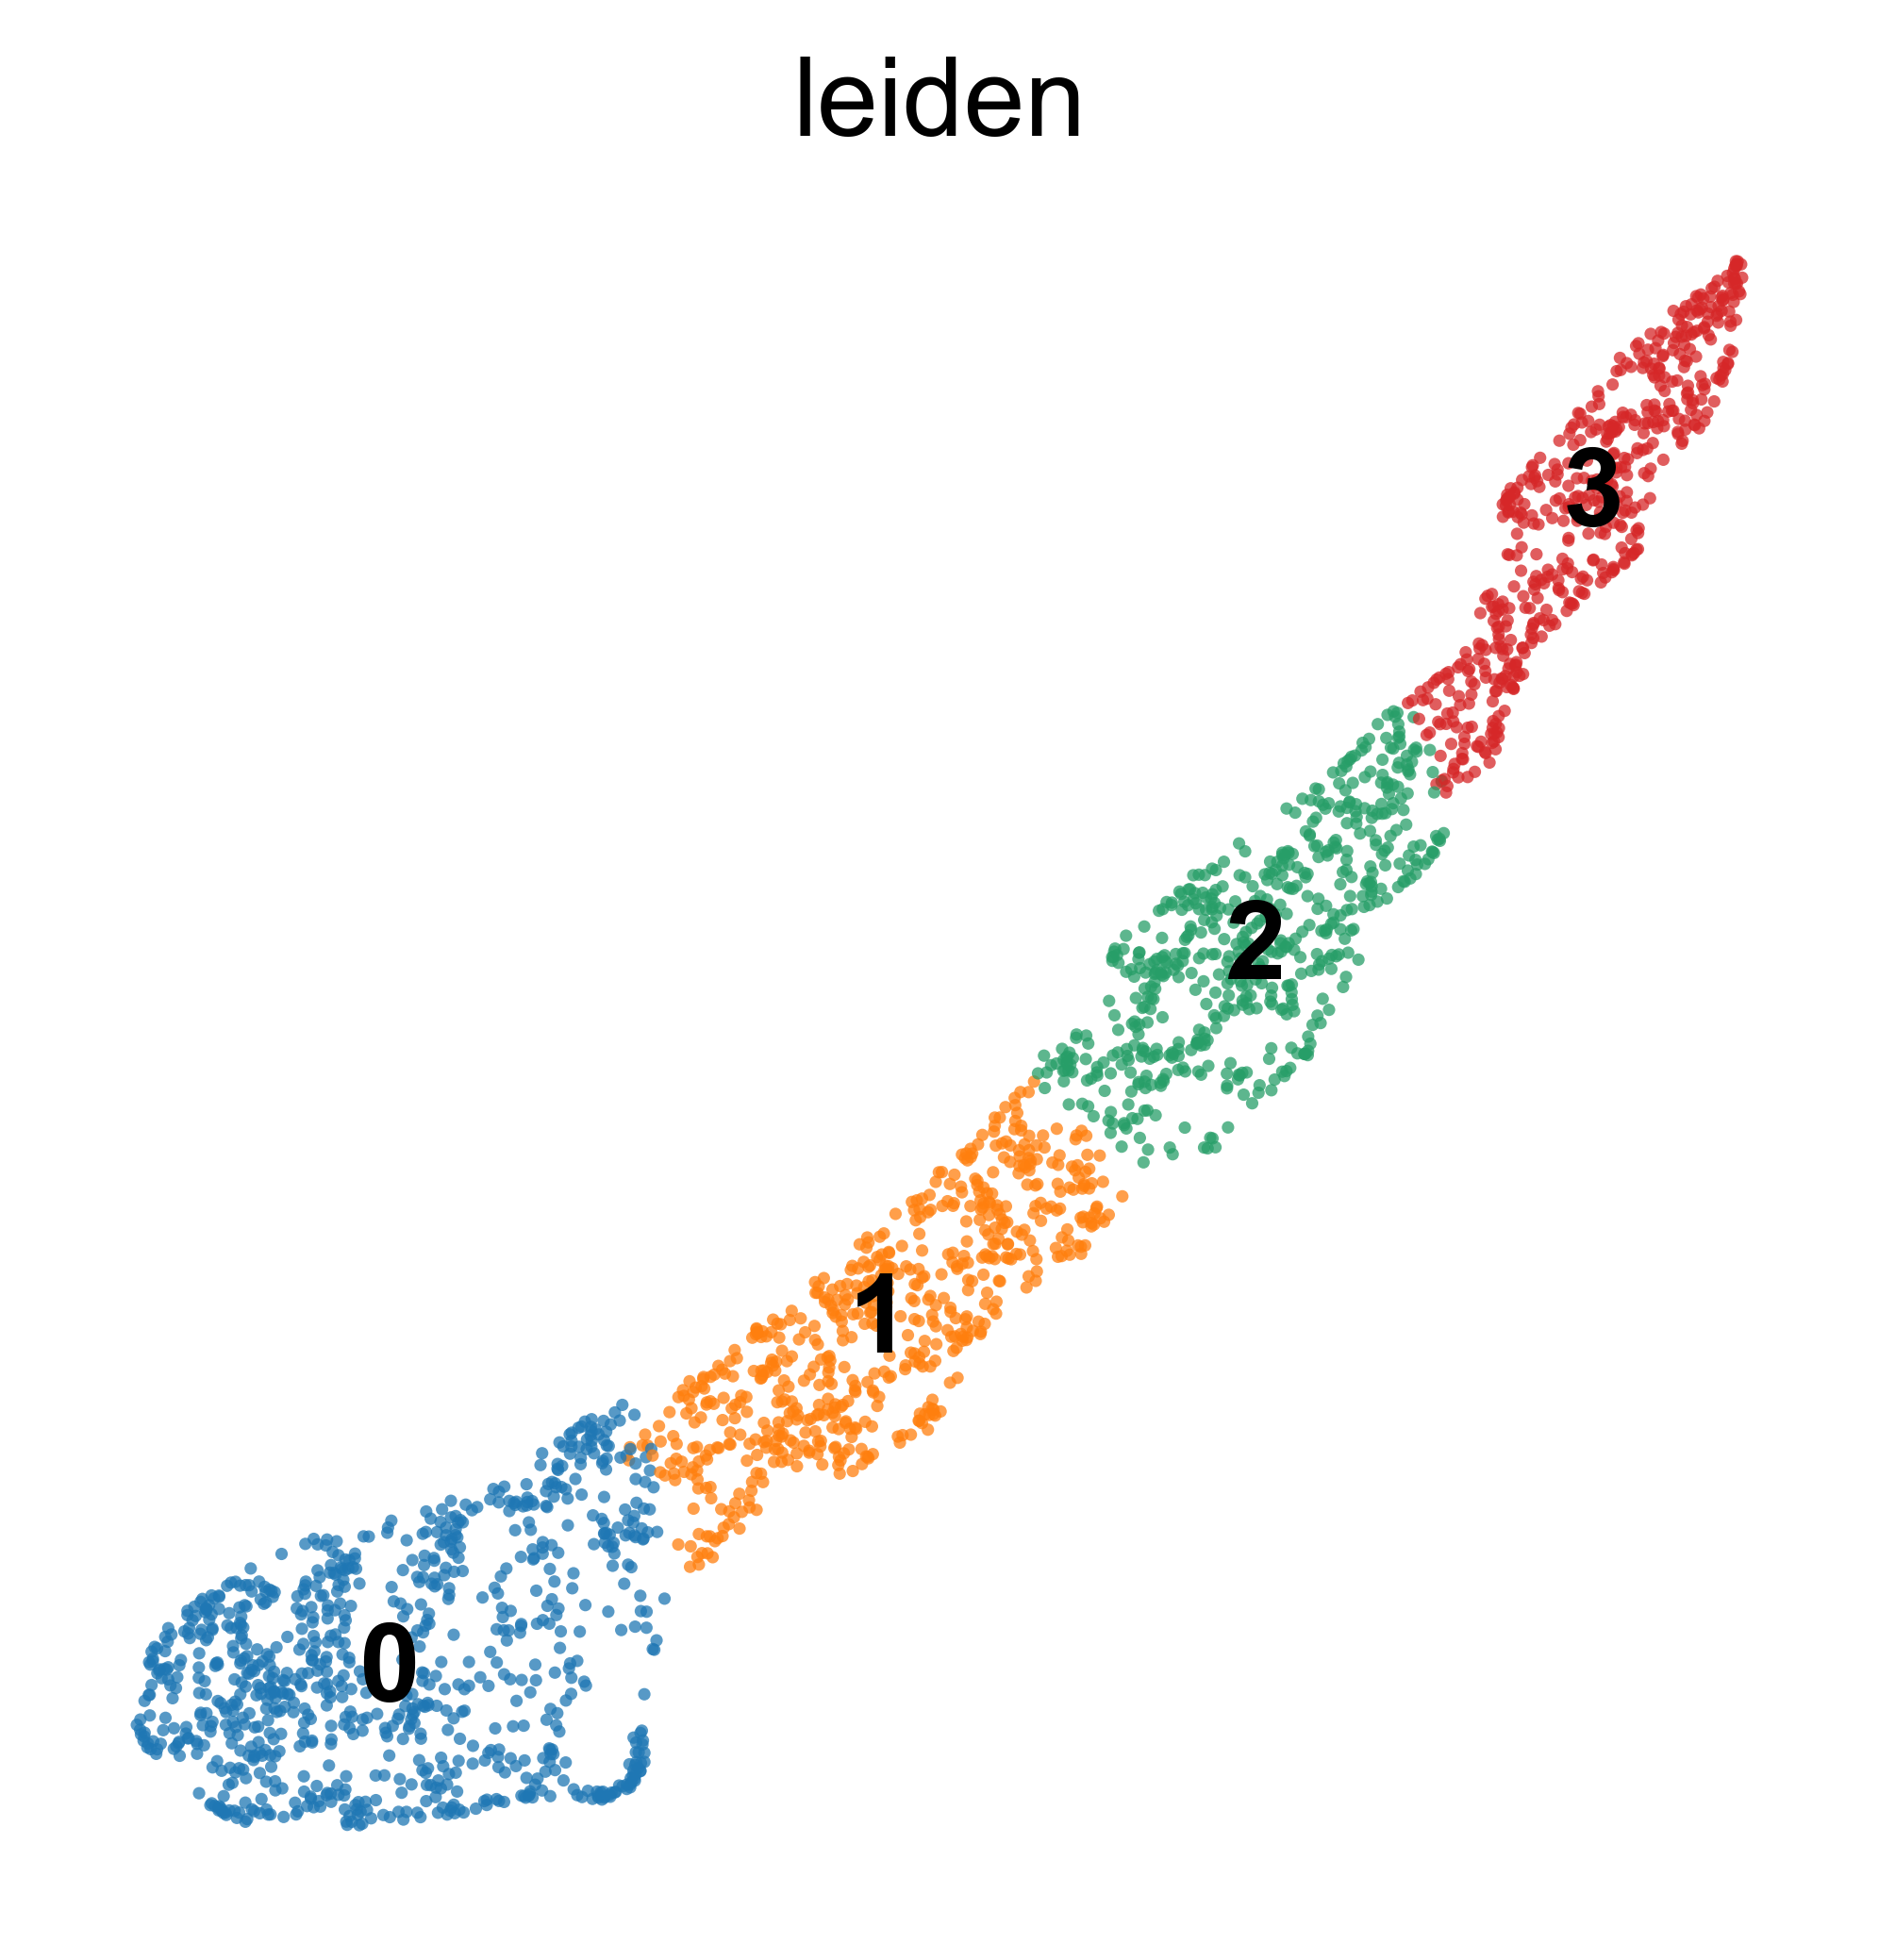

In [88]:
# Clustering
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=3)
sc.tl.leiden(adata,.1)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, 0.25, init_pos='paga')
sc.pl.umap(adata,color=['leiden'], alpha=.75, s=10, legend_loc='on data', show=False)

In [89]:
from cellrank.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata).compute_cytotrace(layer='X')

Computing CytoTRACE score with `12282` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


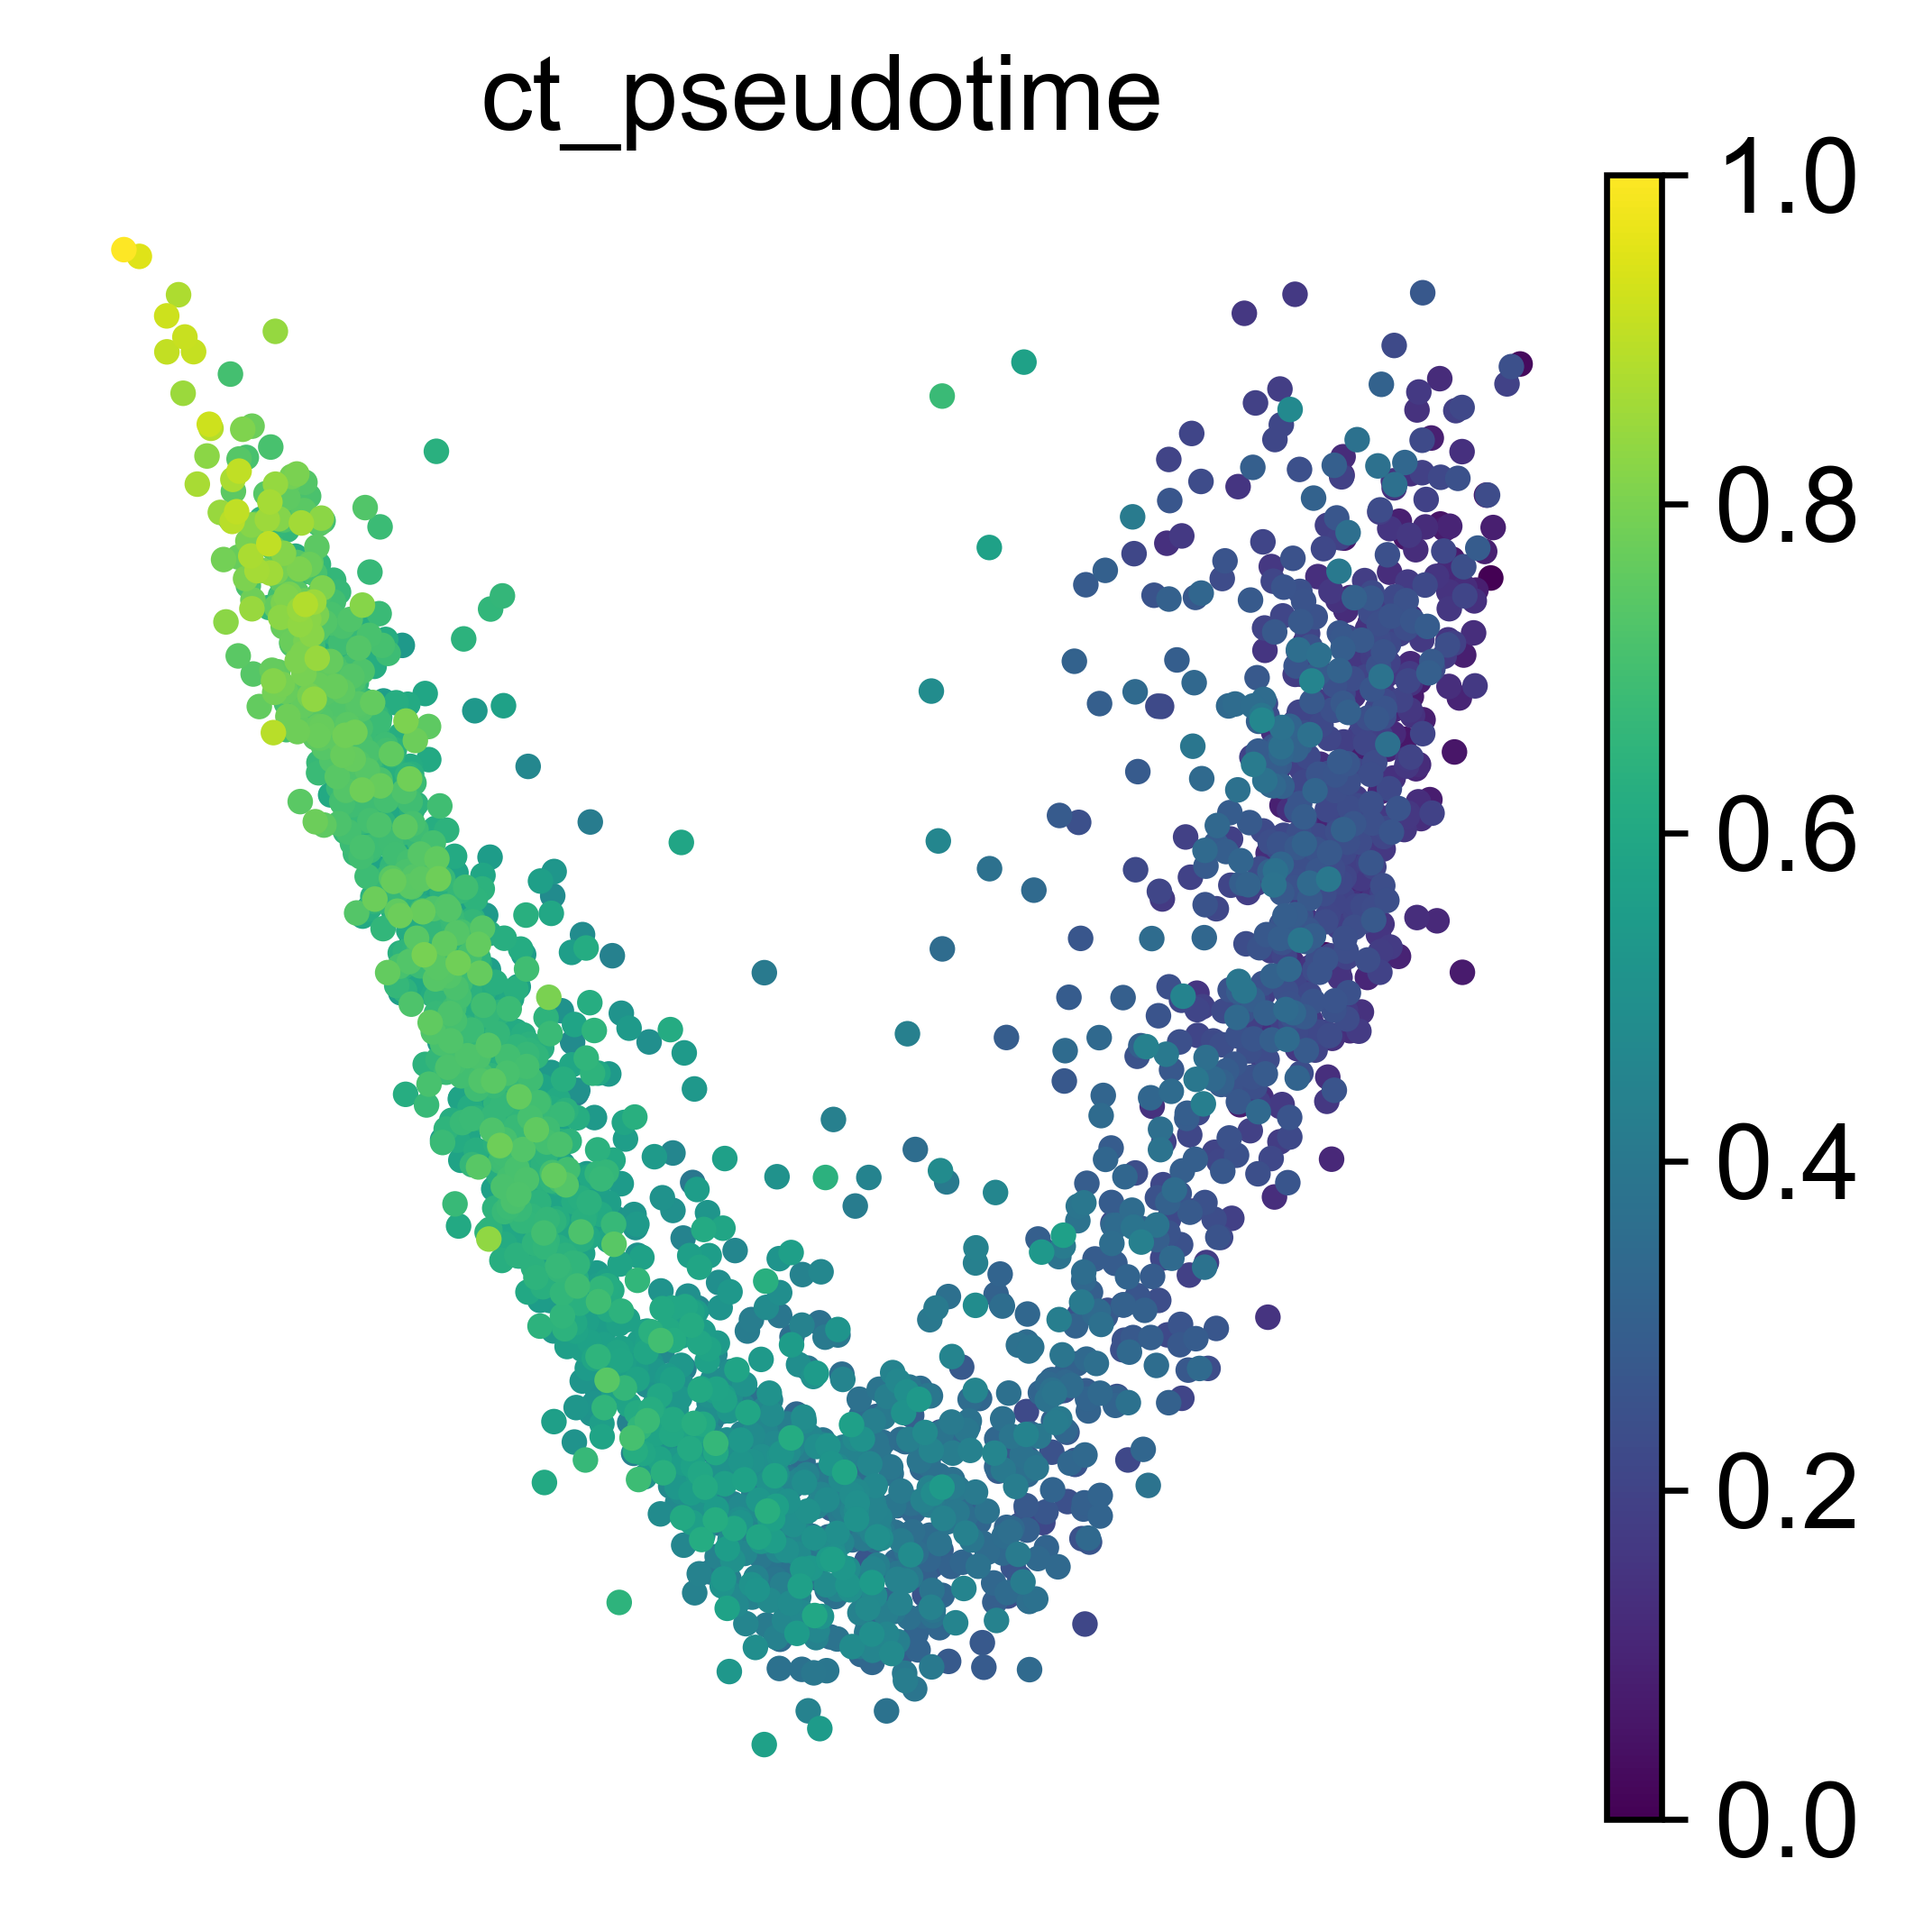

In [90]:
sc.pl.embedding(
    adata,
    basis='X_pca',
    color='ct_pseudotime'
)

<Axes: title={'center': 'ct_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

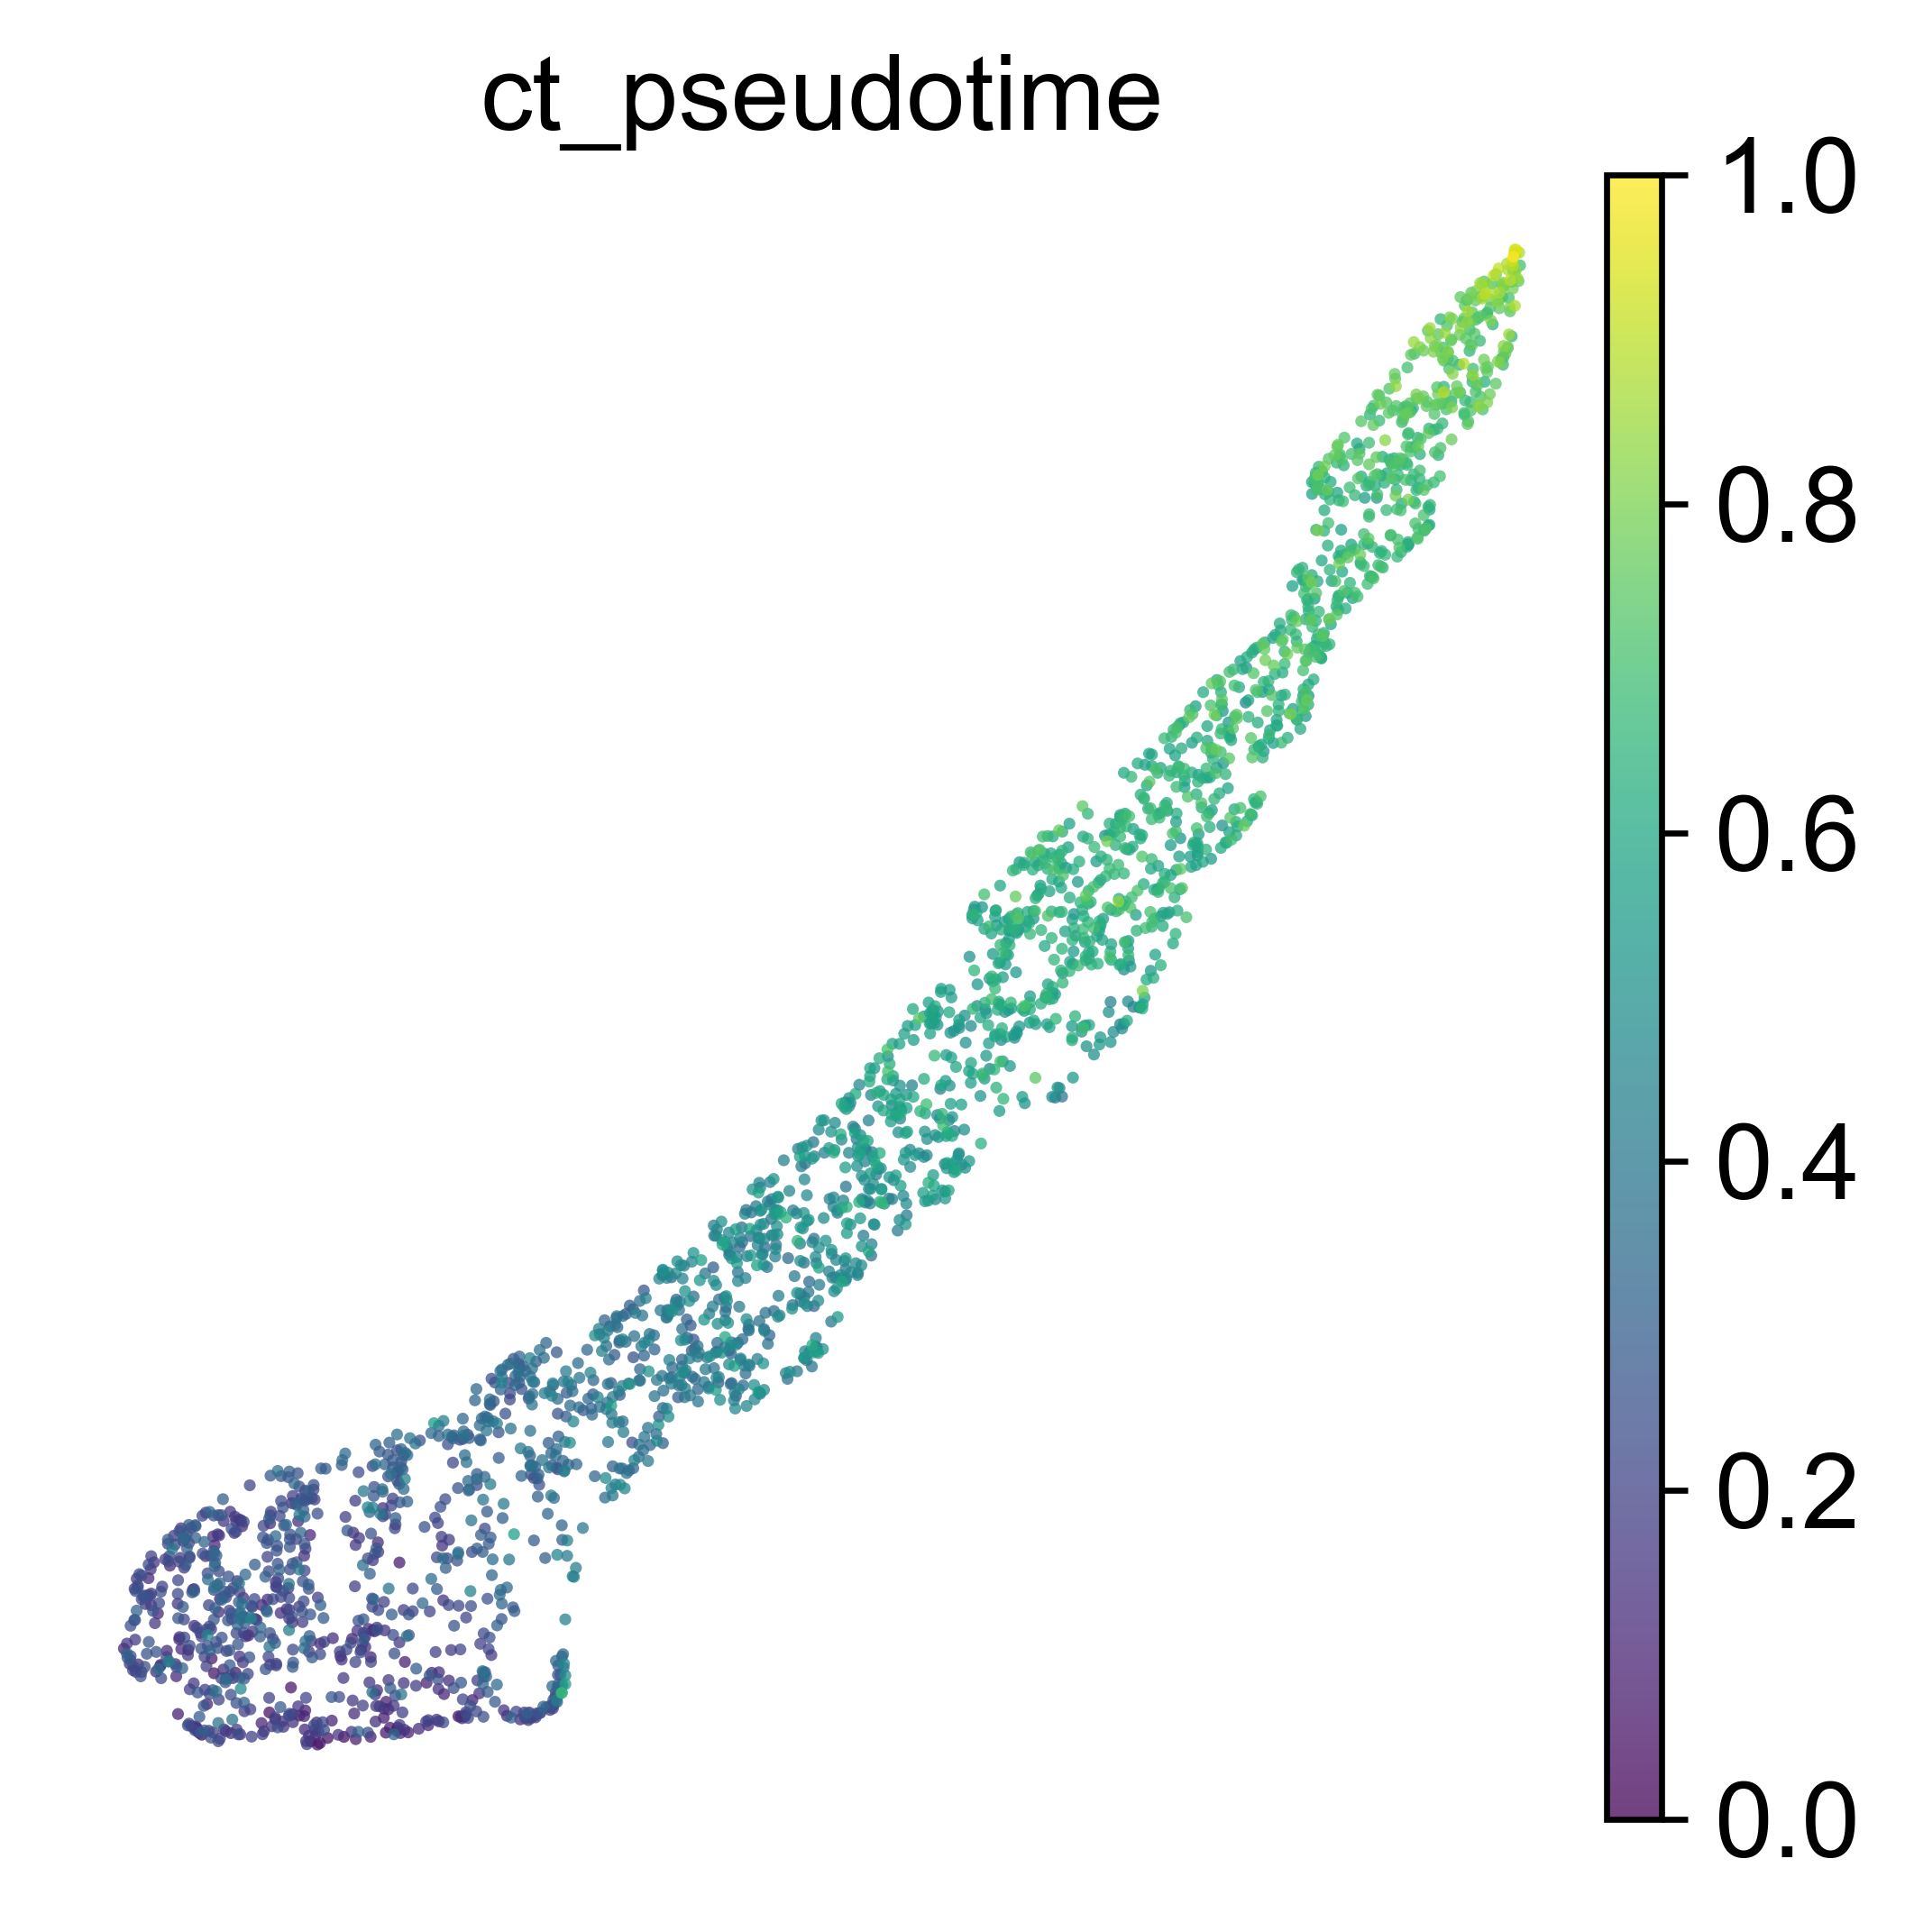

In [91]:
sc.pl.umap(adata, groups='leiden', color='ct_pseudotime', cmap='viridis', legend_loc='on data', s=10, alpha=.75, show=False)

In [123]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=20)

Computing transition matrix based on pseudotime


100%|██████████| 2589/2589 [00:00<00:00, 10472.33cell/s]


    Finish (0:00:00)


CytoTRACEKernel[n=2589, dnorm=False, scheme='soft', b=10.0, nu=20]

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


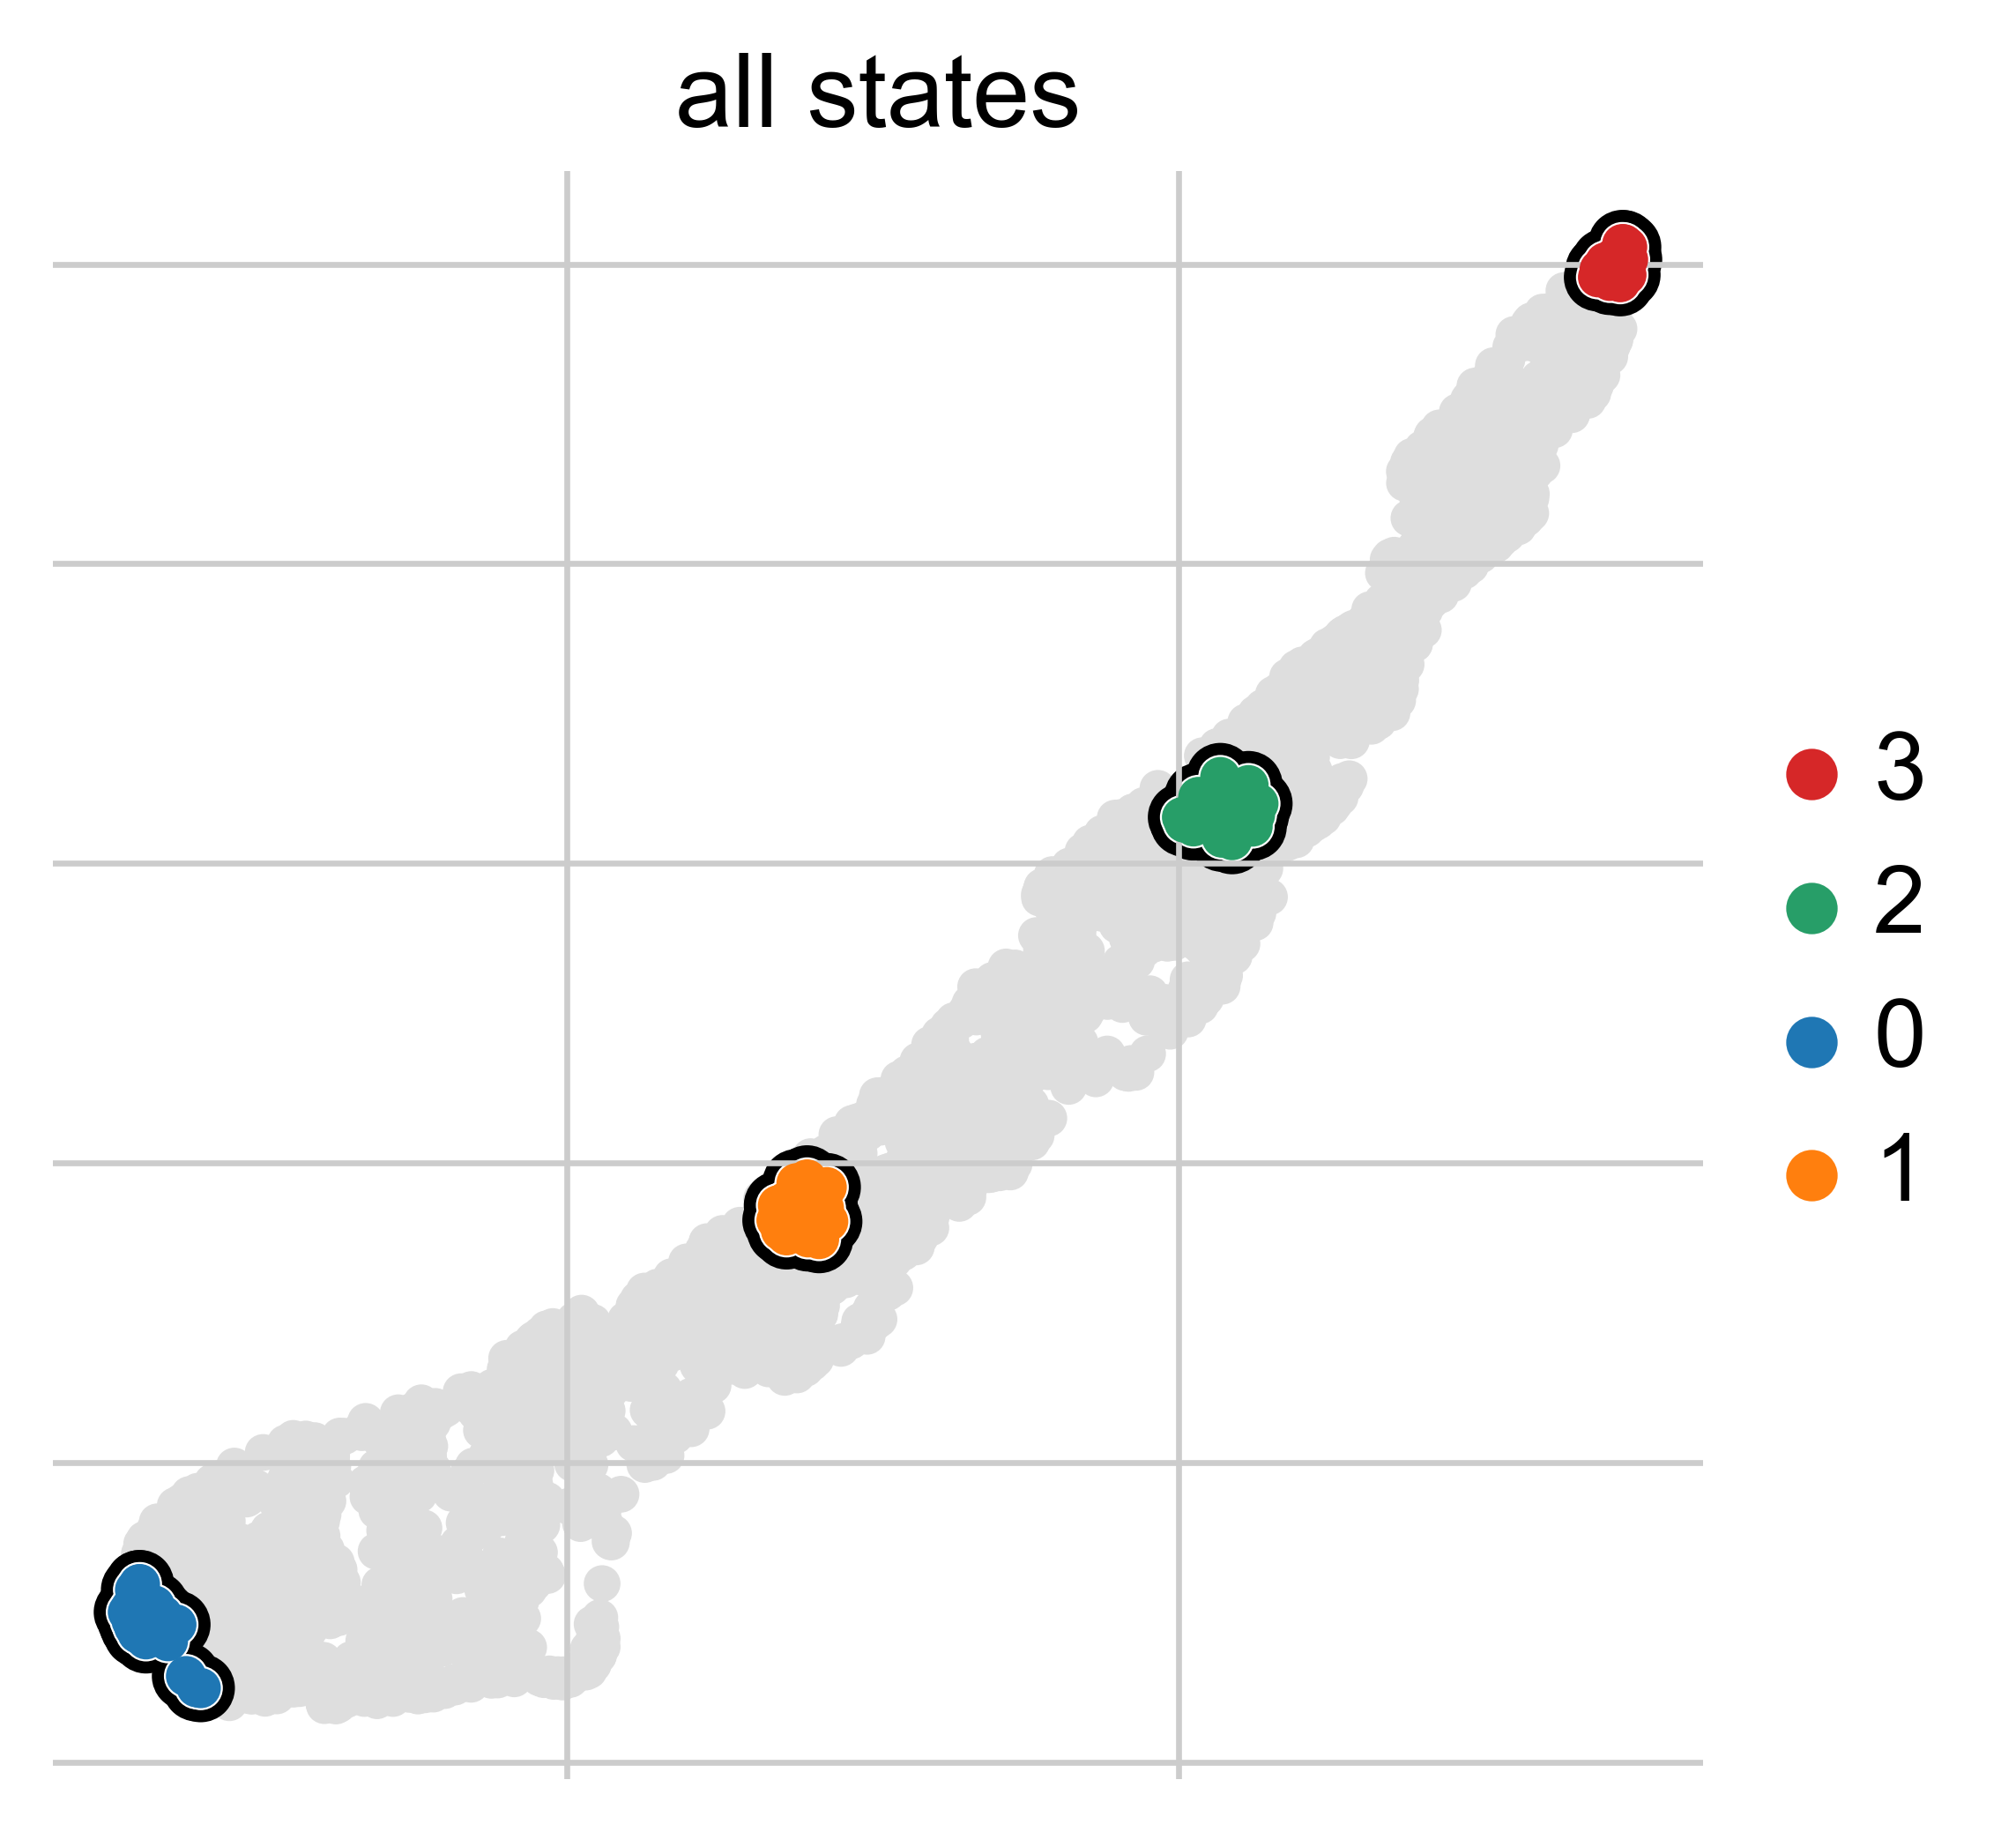

In [124]:
g = cr.estimators.GPCCA(ctk)
g.fit(cluster_key="leiden", n_states=4)
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

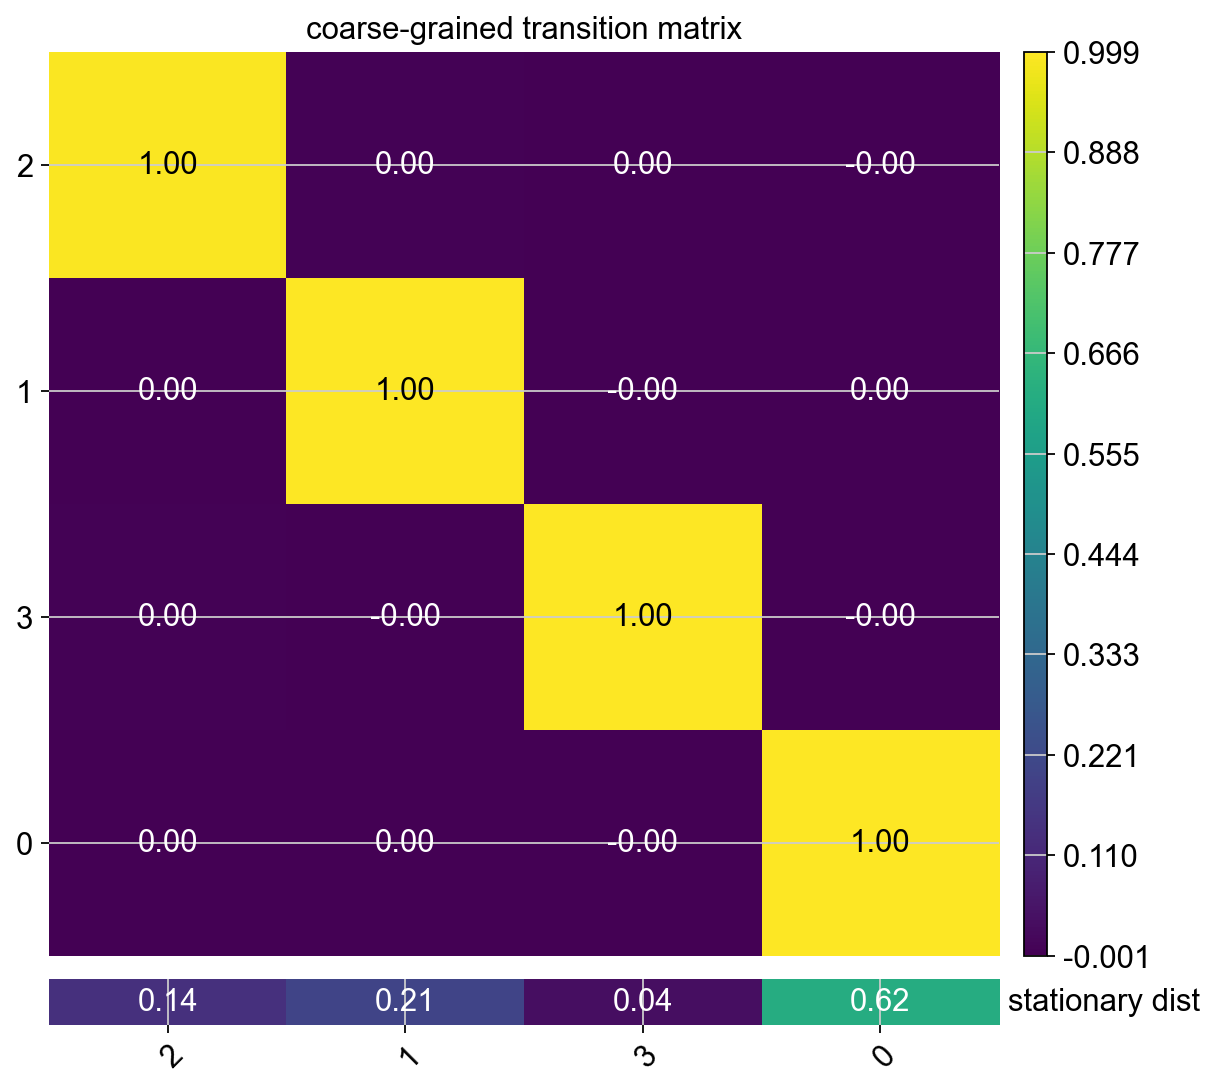

In [125]:
g.plot_coarse_T()

|  Cluster  |  State  |
| --------- | ------- |
|    3      | Initial |
|    2      | Transition |
|    1      | Transition |
|    0      | Terminal |

Based off ascending order of coarse stationary distribution, this seems to be the approximate order of development, neatly fitting with stages E6.75-8

In [132]:
cell_dict = {
    'E6.75': ['3'],
    'E7': ['2'],
    'E7.5': ['1'],
    'E8': ['0']
}

adata.obs['cell_type'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'cell_type'] = i

adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type']

cell_407          E8
cell_410          E8
cell_419          E8
cell_495          E8
cell_512          E8
               ...  
cell_139218       E7
cell_139228    E6.75
cell_139243    E6.75
cell_139244    E6.75
cell_139272    E6.75
Name: cell_type, Length: 2589, dtype: category
Categories (4, object): ['E6.75', 'E7', 'E7.5', 'E8']

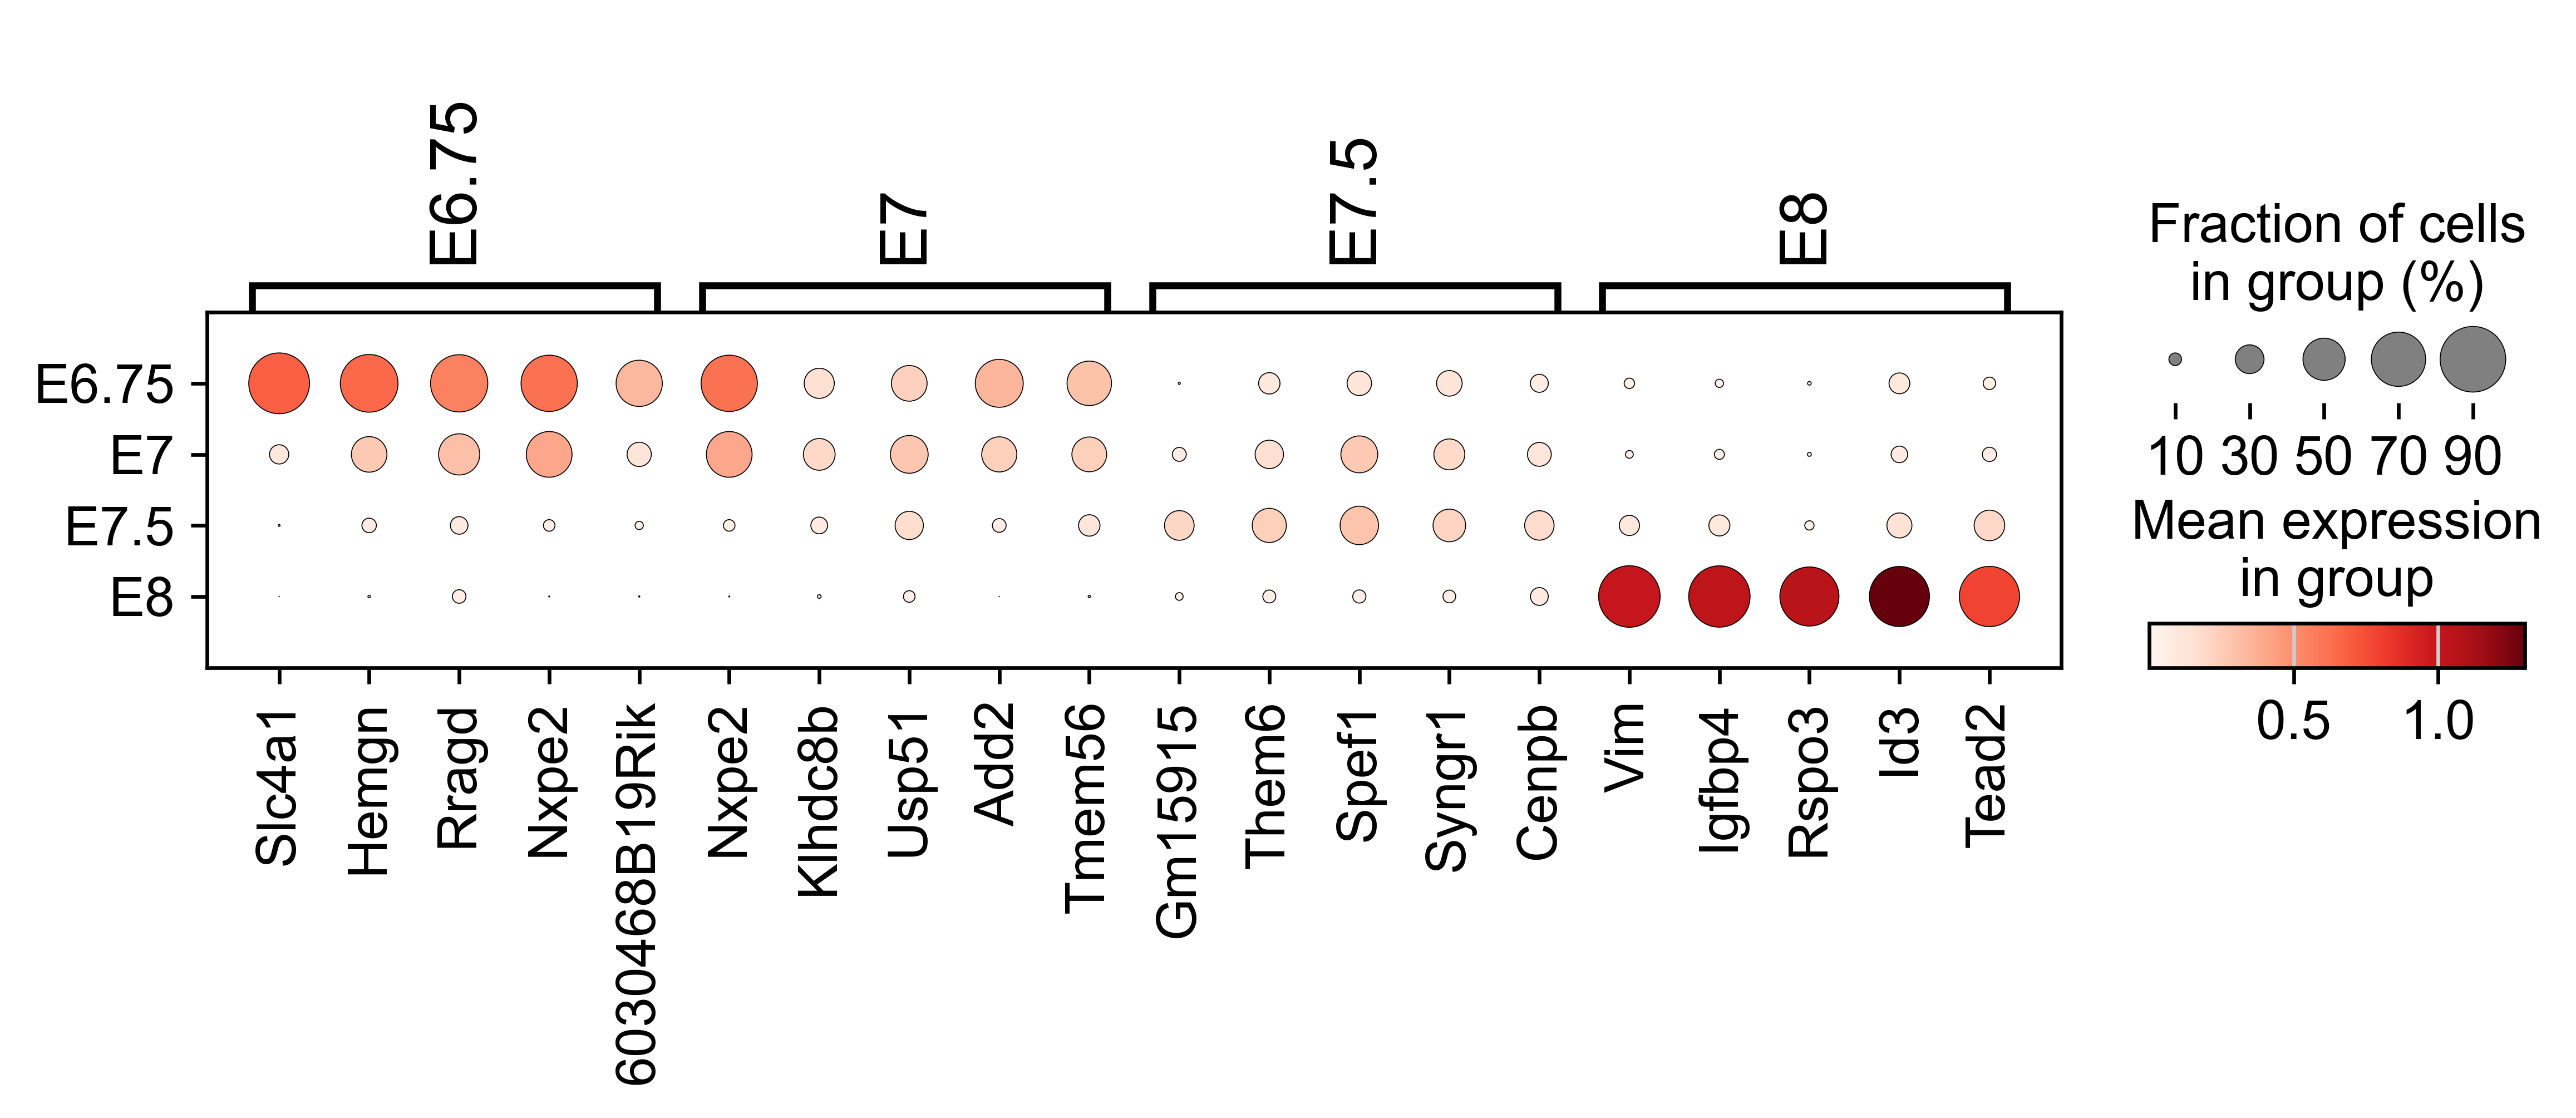

In [133]:
sc.tl.rank_genes_groups(adata, use_raw=False, groupby="cell_type")
sc.tl.filter_rank_genes_groups(adata, min_fold_change=.7, min_in_group_fraction=.3, max_out_group_fraction=.25)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="cell_type", dendrogram=False, key='rank_genes_groups_filtered')

While the transitional states are slightly unclear, the initial and terminal classifications seem to closely align with literature estimates for E6.5 and E8 given the selected genes and their high rates of expression.

Source: Qiu, C., Cao, J., Martin, B.K. et al. Systematic reconstruction of cellular trajectories across mouse embryogenesis. Nat Genet 54, 328–341 (2022). https://doi.org/10.1038/s41588-022-01018-x